In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [224]:
data_loc = "D:/Beam Characterization/2019_5_8/"
fname = "2019_05_08_flow_rate_no_sweep.hdf"

In [225]:
with h5py.File(data_loc+fname, 'r') as f:
    runs = list(f.keys())
    for name in f.keys():
        print(name)

1557344605 new_spot
1557345365 frequency_changed_due_to_unlock
1557345426 frequency_changed_due_to_unlock
1557345452 flow_rate
1557346014 new_spot
1557346192 flow_rate
1557346626 new_spot
1557346720 flow_rate


In [226]:
flow_rate = [40, 10, 40, 20, 40, 60, '60_40', 40, 80, 40]

run_name = '1557345452 flow_rate'
def load_data(run_name):
    fast_daq = {}
    with h5py.File(data_loc+fname, 'r') as f:
        grp = f[run_name]
        readout = grp['readout']
        print('run description :',grp.attrs['run_description'])
        wavemeter = readout['Bristol671A'].value
        fast_start = grp.attrs['time_offset']
        for dset in readout['PXIe-5171'].items():
            fast_daq[dset[0]] = dset[1].value
    return fast_daq, wavemeter

fast_daq, wavemeter = load_data(run_name)

run description : flow rate Q23 40 -> 10 -> 40 -> 20 -> 40 -> 60 -> 40 -> 80


In [227]:
def integrate_signals(fast_daq, dx = 1/1e5, bg = (1800,2000) , sig = (200,1800) ,uv_lowlimit = 100, yag_lowlimit = 300):
    # check when yag fires
    yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > yag_lowlimit]

    # integrating the pmt signal and subtracting the background
    integrals = []
    factor_bg = np.ptp(sig)/np.ptp(bg)
    for idx in yag_fire:
        if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > uv_lowlimit:
            data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
            background = np.trapz(data_f[bg[0]:bg[1]], dx=dx)
            signal = np.trapz(data_f[sig[0]:sig[1]], dx=dx)-factor_bg*background
            integrals.append((idx,signal*-1,background*-1))
    integrals = np.array(integrals)
    return integrals

integrals = integrate_signals(fast_daq)

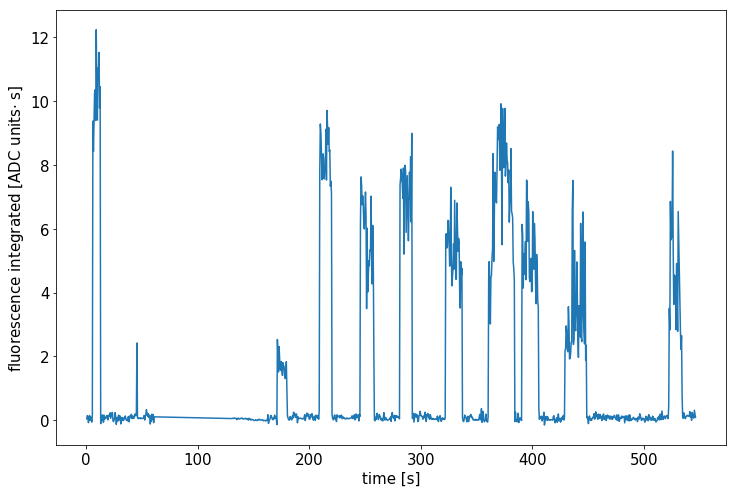

In [228]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(integrals[:,0]*1/2, integrals[:,1])

ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

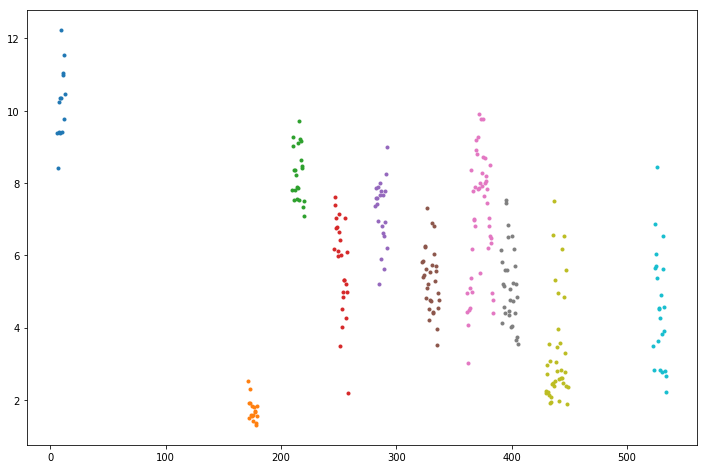

In [229]:
# group integrated signals by variable
import more_itertools as mit

def group_signals(integrated_signals, min_signal = 1.2, min_len = 10, allowed_gap = 10):
    grouped = [list(group) for group in mit.consecutive_groups(np.where(integrated_signals[:,1] > min_signal)[0])]

    # some filtering of groups
    grouped = [g for g in grouped if len(g) > min_len]

    tmp = [grouped[0]]
    idx = 1
    while True:
        if idx == len(grouped):
            break
        group = grouped[idx]
        group_p = grouped[idx-1]
        if (group[0] - group_p[-1]) < allowed_gap:
            tmp[-1].extend(group)
        else:
            tmp.append(group)
        idx += 1

    grouped = tmp
    return grouped

grouped_by_flow = group_signals(integrals)

fig, ax = plt.subplots(figsize = (12,8))
for group in grouped_by_flow:
    ax.plot(integrals[:,0][group]*1/2, integrals[:,1][group], '.')

In [230]:
def calculate_signal_mean(variable, grouped, integrated_signals):
    var_signal_mean = []
    for var, group in zip(variable, grouped):
        mean = np.mean(integrated_signals[:,1][group])
        stderr = np.std(integrated_signals[:,1][group])
        var_signal_mean.append((var, mean, stderr))
    return var_signal_mean

In [231]:
flow_signal = calculate_signal_mean(flow_rate, grouped_by_flow, integrals)

In [232]:
# list of tuples with indices, first index specifies a flow rate in the flow_signal list, the second index corresponds 
# to the corresponding 40 sccm normalization measurement
normalize_by = [(1,0),(3,2),(5,4),(8,7)]

10 40 0.16938524579174447
20 40 0.6888412552660297
60 40 0.7369552823096779
80 40 0.6381513709799634
40 40 0.8094507234817203
40 40 0.8721531175588115
40 40 0.7186297086450077


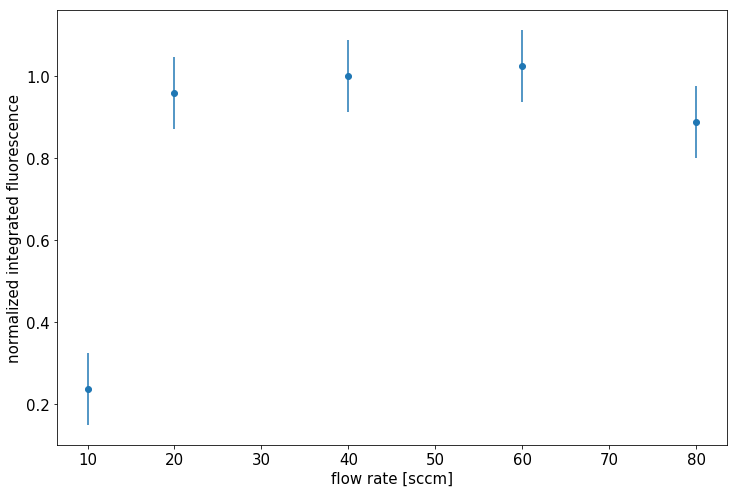

In [233]:
# normalize every integrated signal size by the closest 40 sccm measurement
def normalize_var_signals(normalize_indices, var_signal):
    signal_normalized = []
    for indices in normalize_indices:
        a,b = indices
        var = var_signal[a][0]
        ratio = var_signal[a][1]/var_signal[b][1] 
        print(var, var_signal[b][0], ratio)
        signal_normalized.append((var, ratio))

    tmp = []
    tmp_var = []
    for ida, idb in zip(normalize_indices[1:], normalize_indices[:-1]):
        a,b = ida[1], idb[1]
        var = var_signal[a][0]
        ratio = var_signal[a][1]/var_signal[b][1]  
        print(var, var_signal[b][0], ratio)
        tmp.append(ratio)
        tmp_var.append(var)
    signal_normalized.append((np.mean(var), np.mean(ratio)))
    signal_normalized = [(s[0], s[1], np.std(tmp)) for s in signal_normalized]
    return signal_normalized

signal_normalized = normalize_var_signals(normalize_by, flow_signal)

# normalizing to 40 sccm
signal_normalized = [(s[0], s[1]/signal_normalized[4][1], s[2]/signal_normalized[4][1]) for s in signal_normalized]

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar([val[0] for val in signal_normalized], [val[1] for val in signal_normalized], 
            yerr = [val[2] for val in signal_normalized], fmt = '.', ms = 12)
ax.set_xlabel('flow rate [sccm]', fontsize = 15)
ax.set_ylabel('normalized integrated fluorescence', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

In [234]:
flow_spot_one = signal_normalized.copy()

## Spot 2

In [235]:
flow_rate = [40,10,40,20,40,60,40,80,40]

run_name = '1557346192 flow_rate'
fast_daq, wavemeter = load_data(run_name)
integrals = integrate_signals(fast_daq)

run description : flow rate Q23 40 -> 10 -> 40 -> 20 -> 40 -> 60 -> 40 -> 80


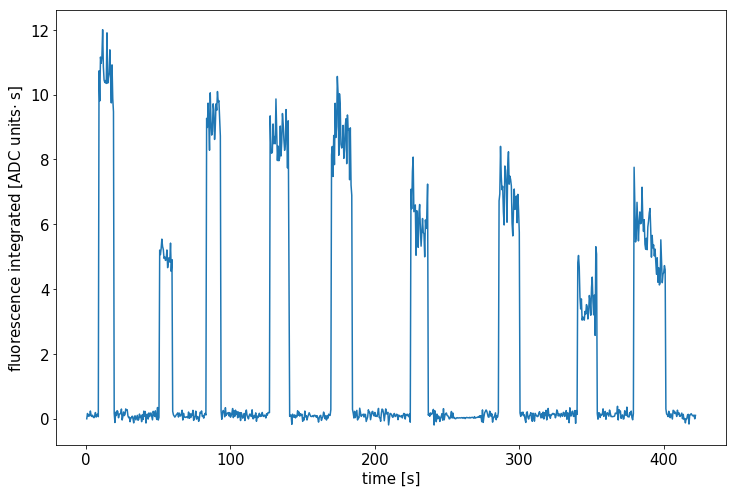

In [236]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(integrals[:,0]*1/2, integrals[:,1])

ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

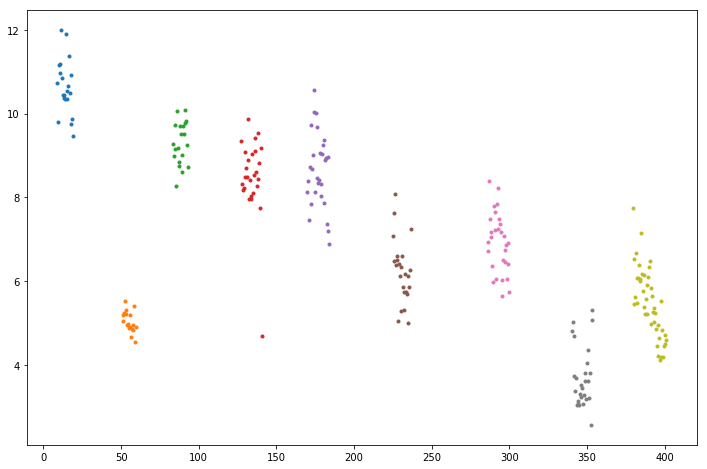

In [237]:
grouped_by_flow = group_signals(integrals)

fig, ax = plt.subplots(figsize = (12,8))
for group in grouped_by_flow:
    ax.plot(integrals[:,0][group]*1/2, integrals[:,1][group], '.')

10 40 0.47304071025241956
20 40 0.9136618436526462
60 40 0.720429806383608
80 40 0.5355791126930665
40 40 0.8734993161968538
40 40 0.9300385581793207
40 40 0.7998719483073016


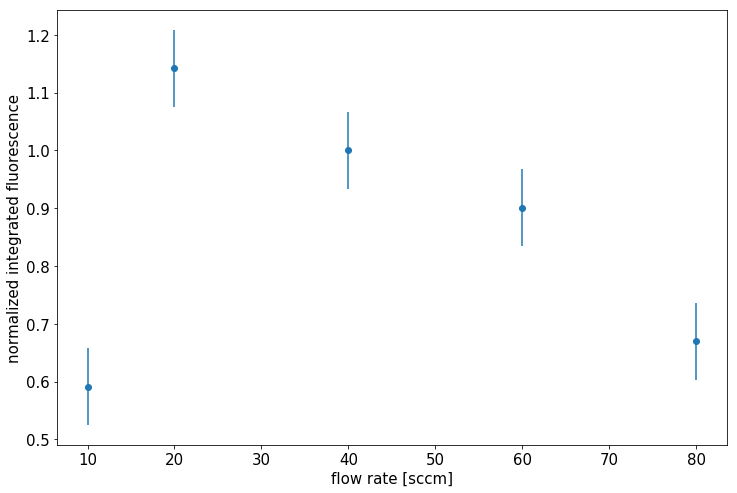

In [238]:
normalize_by = [(1,0),(3,2),(5,4),(7,6)]

flow_signal = calculate_signal_mean(flow_rate, grouped_by_flow, integrals)
signal_normalized = normalize_var_signals(normalize_by, flow_signal)

# normalizing to 40 sccm
signal_normalized = [(s[0], s[1]/signal_normalized[4][1], s[2]/signal_normalized[4][1]) for s in signal_normalized]

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar([val[0] for val in signal_normalized], [val[1] for val in signal_normalized], 
            yerr = [val[2] for val in signal_normalized], fmt = '.', ms = 12)
ax.set_xlabel('flow rate [sccm]', fontsize = 15)
ax.set_ylabel('normalized integrated fluorescence', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

In [239]:
flow_spot_two = signal_normalized.copy()

## Spot 3

In [240]:
flow_rate = [40,10,40,20,40,60,40,80,40,25,40,30,40,35,40,5,40,15]

run_name = '1557346720 flow_rate'
fast_daq, wavemeter = load_data(run_name)
integrals = integrate_signals(fast_daq)

run description : flow rate Q23 40 -> 10 -> 40 -> 20 -> 40 -> 60 -> 40 -> 80


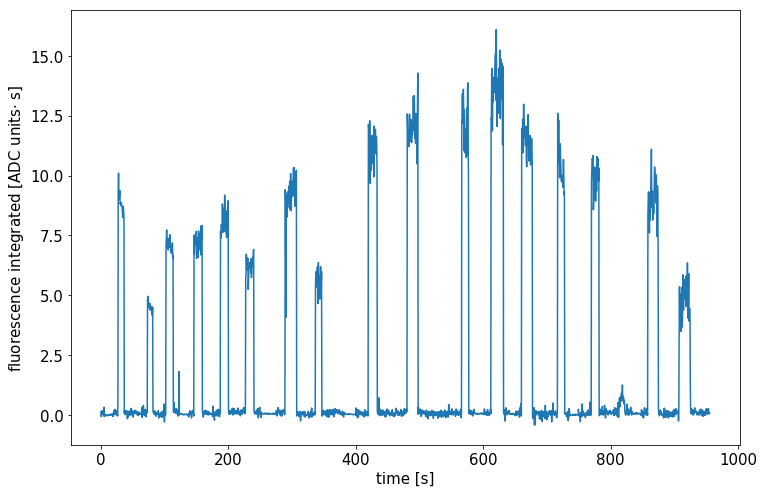

In [241]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(integrals[:,0]*1/2, integrals[:,1])

ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

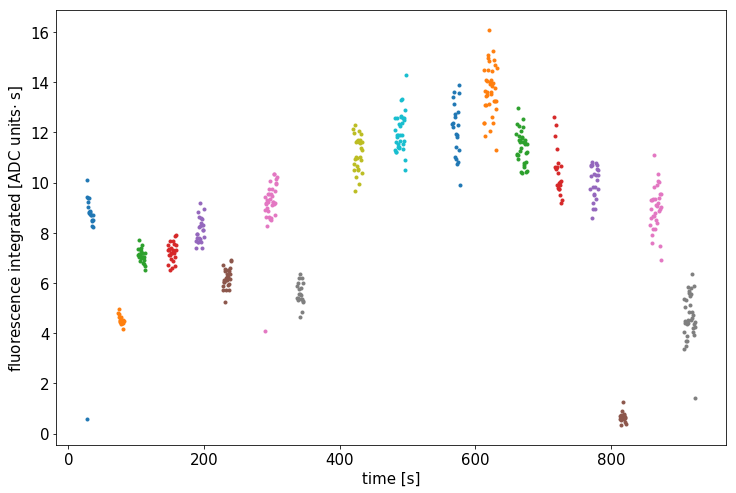

In [242]:
grouped_by_flow = group_signals(integrals, min_signal = 0.3)

fig, ax = plt.subplots(figsize = (12,8))
for group in grouped_by_flow:
    ax.plot(integrals[:,0][group]*1/2, integrals[:,1][group], '.')
    
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

10 40 0.5345383212531998
20 40 1.0210986922560794
60 40 0.7647044630014117
80 40 0.6081848180189235
25 40 1.0772244538699782
30 40 1.1284336054433666
35 40 0.9123797102679564
5 40 0.06675973021908961
15 40 0.5174489991831666
40 40 0.8378031998015714
40 40 1.1441394759867403
40 40 1.1322824939743639
40 40 1.2151743873590242
40 40 1.0862667094205514
40 40 0.9426291135661173
40 40 0.8741310932670676
40 40 0.8986777988790621


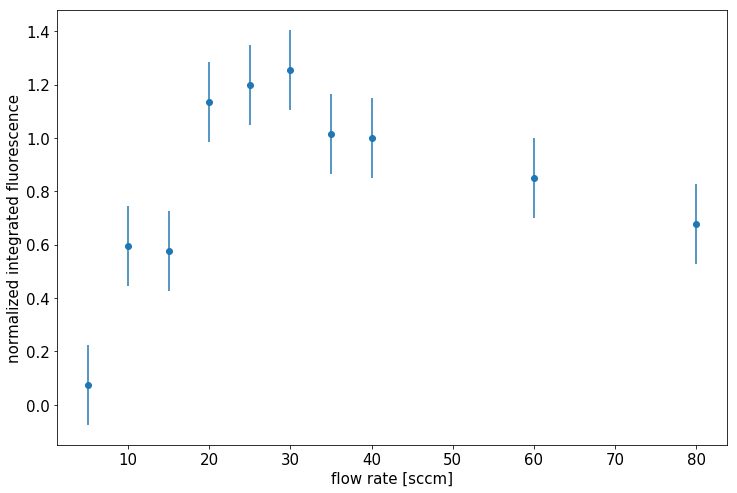

In [243]:
normalize_by = [(idx,idx-1) for idx in range(1,19,2)]

flow_signal = calculate_signal_mean(flow_rate, grouped_by_flow, integrals)
signal_normalized = normalize_var_signals(normalize_by, flow_signal)

# # normalizing to 40 sccm
idx_norm = -1
signal_normalized = [(s[0], s[1]/signal_normalized[idx_norm][1], s[2]/signal_normalized[idx_norm][1]) for s in signal_normalized]

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar([val[0] for val in signal_normalized], [val[1] for val in signal_normalized], 
            yerr = [val[2] for val in signal_normalized], fmt = '.', ms = 12)
ax.set_xlabel('flow rate [sccm]', fontsize = 15)
ax.set_ylabel('normalized integrated fluorescence', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

In [244]:
flow_spot_three = signal_normalized.copy()

## All Spots

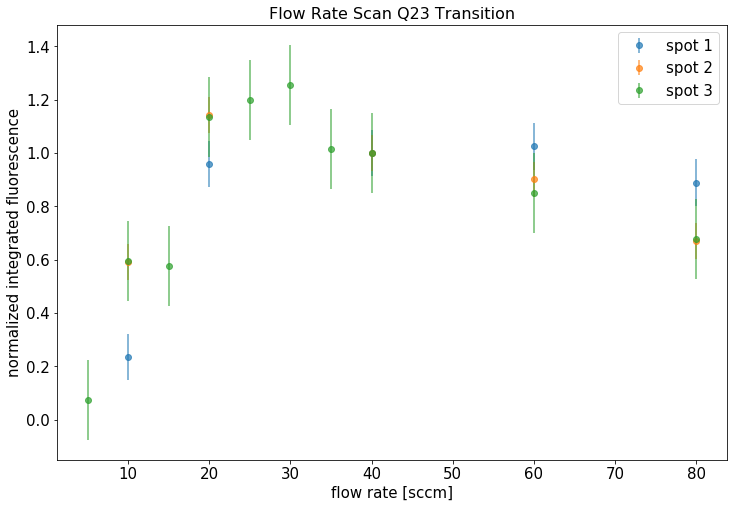

In [250]:
fig, ax = plt.subplots(figsize = (12,8))

for name, spot in zip(['spot 1', 'spot 2', 'spot 3'], [flow_spot_one, flow_spot_two, flow_spot_three]):
    ax.errorbar([val[0] for val in spot], [val[1] for val in spot], 
                yerr = [val[2] for val in spot], fmt = '.', ms = 12, 
                label = name, alpha = 0.7)
    
ax.legend(fontsize = (15))
ax.set_title('Flow Rate Scan Q23 Transition', fontsize = 16)
ax.set_xlabel('flow rate [sccm]', fontsize = 15)
ax.set_ylabel('normalized integrated fluorescence', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

In [251]:
import collections

def groupby_unsorted(seq, key=lambda x: x):
    indexes = collections.defaultdict(list)
    for i, elem in enumerate(seq):
        indexes[key(elem)].append(i)
    for k, idxs in indexes.items():
        yield k, (seq[i] for i in idxs)
        
def weighted_mean(vals, weights):
    mean = np.sum(np.array(vals)*np.array(weights))/np.sum(weights)
    stderr = 1/(np.sqrt(np.sum(weights)))
    return mean, stderr

In [254]:
signal_normalized = flow_spot_one + flow_spot_two + flow_spot_three
signal_normalized_means = []
for key, group in groupby_unsorted(signal_normalized, lambda x: x[0]):
    tmp = []
    tmp_w = []
    for g in group:
        tmp.append(g[1])
        tmp_w.append(1/g[2]**2)
    wm, wstderr = weighted_mean(tmp, tmp_w)
    signal_normalized_means.append((key, wm, wstderr))
signal_normalized_means = np.array(signal_normalized_means)

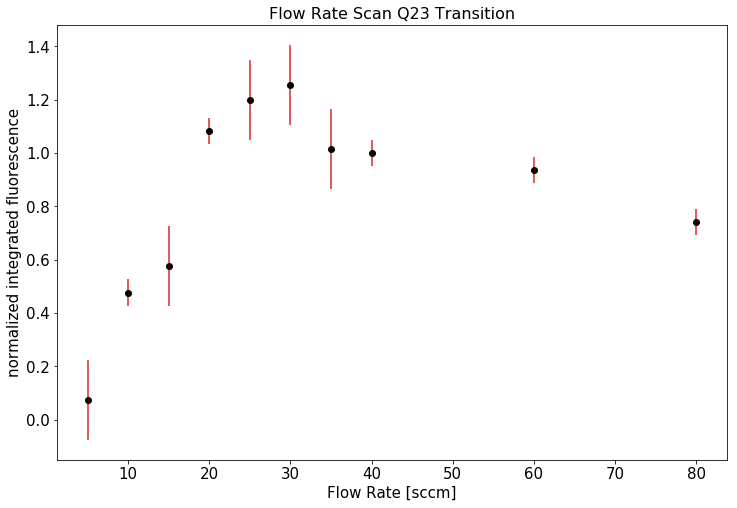

In [257]:
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(signal_normalized_means[:,0], signal_normalized_means[:,1], yerr = signal_normalized_means[:,2], 
            fmt ='.', ecolor = 'C3', ms = 12, color = 'k')

ax.set_title('Flow Rate Scan Q23 Transition', fontsize = 16)
ax.set_xlabel('Flow Rate [sccm]', fontsize = 15)
ax.set_ylabel('normalized integrated fluorescence', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)
fig.savefig('flow_rate_scan.png')